Akhil's Feature Engineering  

For more intuition on what I did here, read my explanation under 3/28 on my research diary: https://docs.google.com/document/d/1DffgdYbgLj4ndfeerdjQI7s_Kbz9yDA7MgPv-Vb_jc4/edit?usp=sharing

labels:
    fall = 1
    impact = 2
    nothing = 3
    squeeze = 4

In [1]:
# Import packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
from scipy import signal

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 

In [2]:
#Force Divider Function
def force_divider(x):
    k_outer = 3.738
    k_inner = 0.368
    dist = x/k_inner
    return (k_outer + k_inner)*dist

#FSR model function
def FSR_model(x):
    return 131.2*np.exp(0.7801*x)/1000

In [3]:
#total impulse function for a single matrix of data 

#iterates over data and computes the total impulse for all sensors over time 
def impulse(data_matrix):
    fsr_data = data_matrix[:,0:13]
    impulse = 0
    for col in np.arange(1,13):
        single_FSR = data_matrix[:,col]
        time = data_matrix[:,0]
        for i in np.arange(0,len(time)-1):
            delta_t = time[i+1]- time[i]
            averagef = (single_FSR[i+1] + single_FSR[i])/2 
            impulse = impulse + averagef*delta_t
    return impulse 

In [4]:
#average jerk function for a single matrix of data 

#iterates over data and computes the average jerk for each sensor over time
#takes the average jerk over all FSR sensors and returns this 
def jerk(data_matrix):
    fsr_data = data_matrix[:,0:13]
    jerk_array = []
    for col in np.arange(1,13):
        single_FSR = data_matrix[:,col]
        time = data_matrix[:,0]
        all_jerks = []
        for i in np.arange(0,len(time)-1):
            delta_t = time[i+1]- time[i]
            delta_f = (single_FSR[i+1] - single_FSR[i])
            all_jerks.append(delta_f/delta_t)
        max_jerk_sensor = np.amax(all_jerks)
        jerk_array.append(max_jerk_sensor)
    max_jerk = np.amax(jerk_array)
    return max_jerk


In [5]:
#average max force readings across all sensors for a single matrix of data 
def max_force(data_matrix):
    fsr_data = data_matrix[:,0:13]
    force_array = [] 
    for col in np.arange(1,13):
        single_FSR = data_matrix[:,col]
        max_force_sensor = np.amax(single_FSR)
        force_array.append(max_force_sensor)
    max_force = np.amax(force_array)
    return max_force

In [6]:
#this block imports all the necessary data. Change the directory lines as needed
resample_size = 100

#falldata
string = "/Users/akhil/Documents/BEST/AkhilProcessingData/fall"
numbers = np.arange(1,15) 
data = []
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    
    #convert time to seconds
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)
    #print(d.head())
    
    #convert to forces
    d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]]  = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]].apply(
        lambda x: force_divider(FSR_model(x*(5/1023))), axis=1).copy()

    d = d.drop(columns = ["IND"])
    
    
    f = d[["time","FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]]
    f = f.set_index("time")
    #f.plot(figsize=(15,10))
    
    
    #d = sp.signal.resample(d,resample_size, axis = 0)
    d = d.to_numpy()
    data.append(d)
    
    

#example data plot to show resampling 
#xnew = np.linspace(1,1000,resample_size)
#ynew = data[1][:,1]
#plt.plot(xnew,ynew)

In [7]:
#impactdata added
string = "/Users/akhil/Documents/BEST/AkhilProcessingData/impact"
numbers = np.arange(1,15)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    #convert time to seconds
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)
    #print(d.head())
    
    #convert to forces
    d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]]  = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]].apply(
        lambda x: force_divider(FSR_model(x*(5/1023))), axis=1).copy()

    d = d.drop(columns = ["IND"])
    
    i = d[["time","FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]]
    i = i.set_index("time")
    
    d = sp.signal.resample(d,resample_size, axis = 0)
    #d = d.to_numpy()
    data.append(d)
    print(jerk(d))
    
#nothingdata added
string = "/Users/akhil/Documents/BEST/AkhilProcessingData/nothing"
numbers = np.arange(1,15)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
   #convert time to seconds
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)
    #print(d.head())
    
    #convert to forces
    d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]]  = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]].apply(
        lambda x: force_divider(FSR_model(x*(5/1023))), axis=1).copy()

    d = d.drop(columns = ["IND"])
    
    n = d[["time","FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]]
    n = n.set_index("time")
    
    d = sp.signal.resample(d,resample_size, axis = 0)
    #d = d.to_numpy()
    data.append(d)
    print(jerk(d)) 
    
    
#squeezedata added
string = "/Users/akhil/Documents/BEST/AkhilProcessingData/squeeze"
numbers = np.arange(1,15)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
   #convert time to seconds
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)
    #print(d.head())
    
    #convert to forces
    d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]]  = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]].apply(
        lambda x: force_divider(FSR_model(x*(5/1023))), axis=1).copy()

    d = d.drop(columns = ["IND"])
    
    s = d[["time","FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"]]
    s = s.set_index("time")
    
    #d = sp.signal.resample(d,resample_size, axis = 0)
    data.append(d)


#create label array
l1 = np.ones((14,), dtype=int) 
l2 = 2*np.ones((14,), dtype=int) 
l3 =  3*np.ones((14,), dtype=int)
l4 =  4*np.ones((14,), dtype=int)
labels = np.concatenate((l1, l2, l3, l4), axis=0)

#print("Matrix Dimensions of data: " + str(np.shape(data)))
#print("Matrix Dimensions of labels: " + str(np.shape(labels)))

#need to reformat data so that it is 2 dimensional 
#nsamples, nx, ny = np.shape(data)
#reformated_data = np.reshape(data,(nsamples, nx*ny))




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; u

5887.302093412226
2254.9458030642513
1349.7527510208563
4469.363283990895
5769.6002587501325
873.5640921778826
18907.359967815177
359.94446611409245
7131.112968457747
1245.735621495997
3040.367461704058
554.1642594920077
1697.4835657444464
2116.6721681771724
85.81048945911469
69.56082923680769
42.9205886097327
34.64929473783354
27.601047834478567
24.26647356250275
189.37193601798376
79.99804011396506
7377.656869696696
532.3651269164321
66.90732828592235
119.49566683388005
47.75919300738364
104.00609933127986


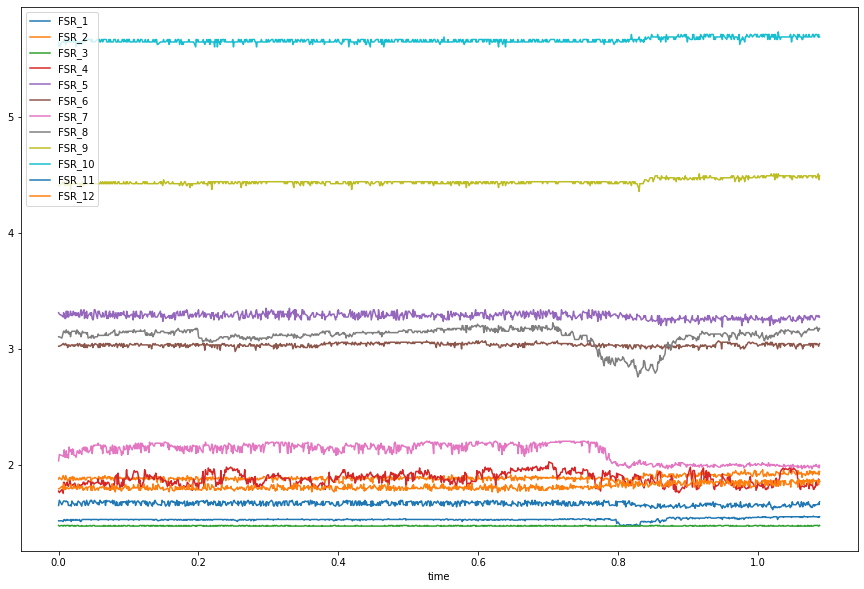

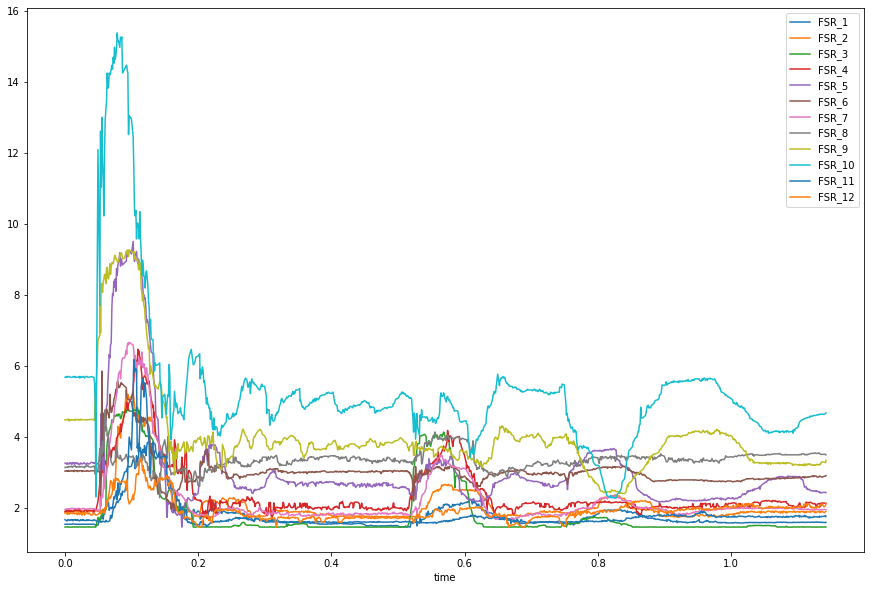

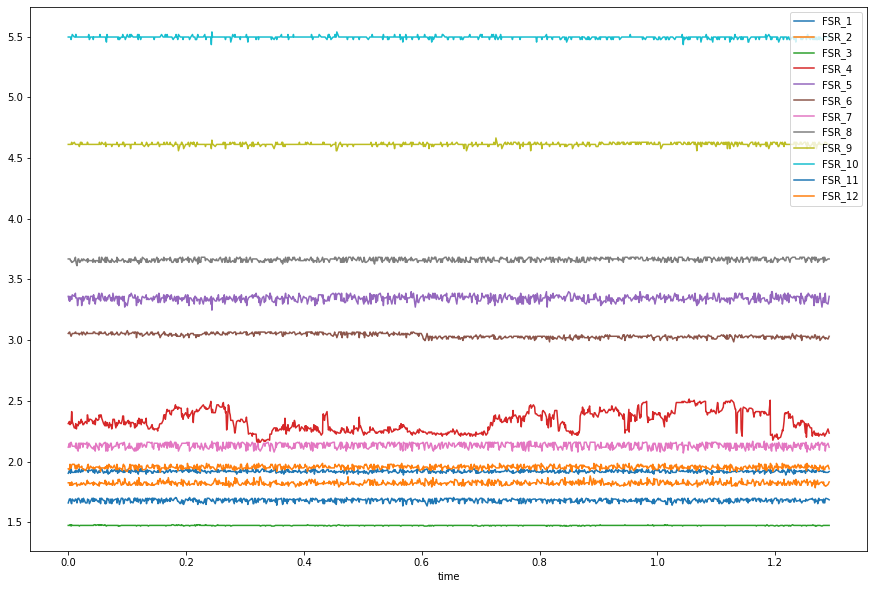

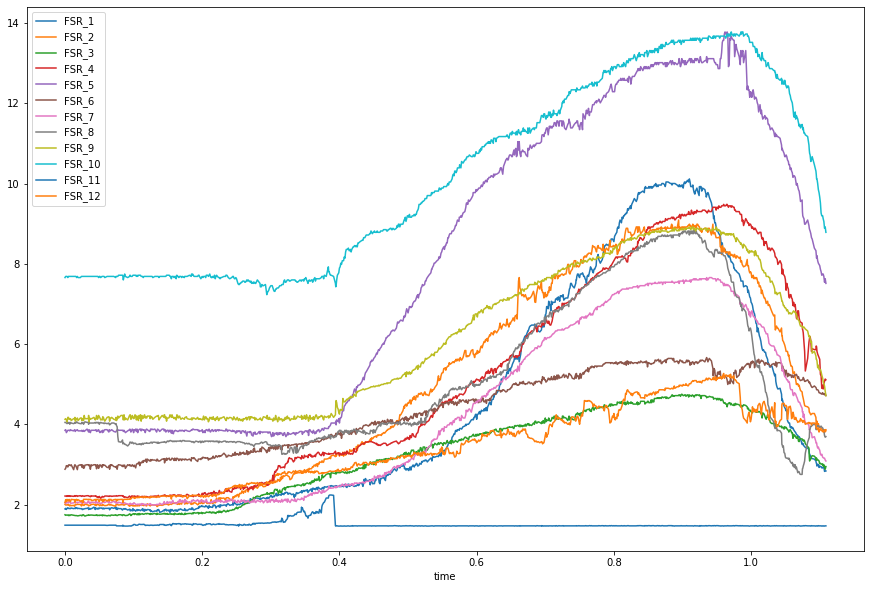

In [18]:
f.plot(figsize=(15,10))
i.plot(figsize=(15,10))
n.plot(figsize=(15,10))
s.plot(figsize=(15,10))


In [58]:
#Naive Bayes Implementation 
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, labels, random_state=0)
nb = GaussianNB().fit(X_train, y_train)
print(nb.score(X_train, y_train))
print(nb.score(X_test, y_test))
print("Predicted labels = " + str(nb.predict(X_test)))
print("Correct labels =   " + str(y_test))

0.9761904761904762
0.7142857142857143
Predicted labels = [4 3 3 2 3 1 3 4 4 3 3 2 2 2]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]


In [59]:
#Random Forest Implementation 
rf = RandomForestClassifier().fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))
print("Predicted labels = " + str(rf.predict(X_test)))
print("Correct labels =   " + str(y_test))

1.0
0.7857142857142857
Predicted labels = [4 2 3 2 1 1 3 4 4 1 1 1 1 2]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]


In [60]:
#Decision Tree Implementation
dt = DecisionTreeClassifier().fit(X_train, y_train)
print(dt.score(X_train, y_train))
print(dt.score(X_test, y_test))
print("Predicted labels = " + str(dt.predict(X_test)))
print("Correct labels =   " + str(y_test))

1.0
0.6428571428571429
Predicted labels = [4 2 2 2 1 1 3 4 4 1 2 4 3 2]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]


In [61]:
#Support Vector Implementation
sv = SVC().fit(X_train, y_train)
print(sv.score(X_train, y_train))
print(sv.score(X_test, y_test))
print("Predicted labels = " + str(sv.predict(X_test)))
print("Correct labels =   " + str(y_test))

0.7857142857142857
0.6428571428571429
Predicted labels = [4 1 1 2 1 1 1 4 4 1 1 1 1 2]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]


In [62]:
#K Nearest Neighbors Implementation
knn = KNeighborsClassifier().fit(X_train, y_train)
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))
print("Predicted labels = " + str(knn.predict(X_test)))
print("Correct labels =   " + str(y_test))

0.47619047619047616
0.7857142857142857
Predicted labels = [4 3 3 1 1 1 3 4 4 1 1 1 3 1]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]


In [63]:
#OnevsRest Implementation 
ovr = OneVsRestClassifier(SVC()).fit(X_train, y_train)
print(ovr.score(X_train, y_train))
print(ovr.score(X_test, y_test))
print("Predicted labels = " + str(ovr.predict(X_test)))
print("Correct labels =   " + str(y_test))

0.9523809523809523
0.8571428571428571
Predicted labels = [4 3 3 2 1 1 3 4 4 1 1 1 1 2]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]
